### Packages

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import copy
import gc
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss # Added for new metrics
from sklearn.manifold import TSNE 
from matplotlib.colors import ListedColormap

# **Importing datasets and preprocessing**

In [17]:
Xs_tr_match1 = np.load("./MIMIC_data_handler/numpy_data_c1/Xstatic_train_match1.npy")    
Xs_te_match1 = np.load("./MIMIC_data_handler/numpy_data_c1/Xstatic_test_match1.npy")

y_tr_match1 = np.load("./MIMIC_data_handler/numpy_data_c1/y_train_match1.npy")      
y_te_match1 = np.load("./MIMIC_data_handler/numpy_data_c1/y_test_match1.npy")   

Xs_tr_match2 = np.load("./eICU_data_handler/numpy_data_c2/Xstatic_train_match2.npy")    
Xs_te_match2 = np.load("./eICU_data_handler/numpy_data_c2/Xstatic_test_match2.npy")   

y_tr_match2 = np.load("./eICU_data_handler/numpy_data_c2/y_train_match2.npy")      
y_te_match2 = np.load("./eICU_data_handler/numpy_data_c2/y_test_match2.npy")  

In [18]:
print("Xs_tr_match1:", Xs_tr_match1.shape)
print("Xs_te_match1:", Xs_te_match1.shape)
print("y_tr_match1:", y_tr_match1.shape)
print("y_te_match1:", y_te_match1.shape)

print("Xs_tr_match2:", Xs_tr_match2.shape)
print("Xs_te_match2:", Xs_te_match2.shape)
print("y_tr_match2:", y_tr_match2.shape)
print("y_te_match2:", y_te_match2.shape)

Xs_tr_match1: (27585, 6)
Xs_te_match1: (6897, 6)
y_tr_match1: (27585,)
y_te_match1: (6897,)
Xs_tr_match2: (34137, 6)
Xs_te_match2: (8535, 6)
y_tr_match2: (34137,)
y_te_match2: (8535,)


No need for feature mapping and engineering, this was all done in the preprocessing notebook.

## **Plot definitions**

In [19]:
def display_evaluation_table(global_model_eval, test_loaders_eval, pos_weights_eval, history_eval, per_client_history_eval, algorithm_name, device_eval='cpu'): # Added suffixes to avoid name clashes
    print(f"\n--- Evaluation Table for {algorithm_name} ---")
    num_clients = len(test_loaders_eval)
    data_sizes = [len(dl.dataset) for dl in test_loaders_eval] 
    total_size = sum(data_sizes)
    table_data = []

    client_final_losses, client_final_accs, client_final_precisions, client_final_recalls, client_final_f1s = [], [], [], [], []
    client_final_roc_aucs, client_final_pr_aucs = [], []

    for i in range(num_clients):
        loss, acc, precision, recall, f1, roc_auc, pr_auc, _, _ = evaluate_model(
            global_model_eval, test_loaders_eval[i], pos_weights_eval[i], device=device_eval
        )
        table_data.append({
            "Level": f"Client {i+1} (Local Eval)", "Loss": f"{loss:.4f}", "Accuracy": f"{acc:.4f}",
            "Precision": f"{precision:.4f}", "Recall": f"{recall:.4f}", "F1 Score": f"{f1:.4f}",
            "ROC-AUC": f"{roc_auc:.4f}", "PR-AUC": f"{pr_auc:.4f}"
        })
        client_final_losses.append(loss * data_sizes[i])
        client_final_accs.append(acc * data_sizes[i])
        client_final_precisions.append(precision * data_sizes[i])
        client_final_recalls.append(recall * data_sizes[i])
        client_final_f1s.append(f1 * data_sizes[i])
        client_final_roc_aucs.append(roc_auc * data_sizes[i])
        client_final_pr_aucs.append(pr_auc * data_sizes[i])
    
    global_loss_final = sum(client_final_losses) / total_size
    global_acc_final = sum(client_final_accs) / total_size
    global_precision_final = sum(client_final_precisions) / total_size
    global_recall_final = sum(client_final_recalls) / total_size
    global_f1_final = sum(client_final_f1s) / total_size
    global_roc_auc_final = sum(client_final_roc_aucs) / total_size
    global_pr_auc_final = sum(client_final_pr_aucs) / total_size

    table_data.append({
        "Level": "Global Model (Avg)", "Loss": f"{global_loss_final:.4f}", "Accuracy": f"{global_acc_final:.4f}",
        "Precision": f"{global_precision_final:.4f}", "Recall": f"{global_recall_final:.4f}", 
        "F1 Score": f"{global_f1_final:.4f}", "ROC-AUC": f"{global_roc_auc_final:.4f}", "PR-AUC": f"{global_pr_auc_final:.4f}"
    })
    df = pd.DataFrame(table_data)
    print(df.to_string())

In [20]:
def plot_tsne_client_data(client_data_X_list, client_data_y_list, client_names, title="t-SNE visualization of client data"):
    # Check if input lists have the same length
    if len(client_data_X_list) != len(client_data_y_list) or len(client_data_X_list) != len(client_names):
        print("Error: Input lists must have the same length.")
        return
    
    custom_cmap = ListedColormap(['orange', 'blue'])

    plt.figure(figsize=(7 * len(client_data_X_list), 6))
    
    # Loop through each client's data
    for i in range(len(client_data_X_list)):
        X_client, y_client, client_name = client_data_X_list[i], client_data_y_list[i], client_names[i]
        
        # Determine the number of samples to use for t-SNE (max 1000)
        n_samples_tsne = min(1000, X_client.shape[0])
        
        # If the client has more samples than n_samples_tsne, randomly select a subset
        if X_client.shape[0] > n_samples_tsne:
            indices = np.random.choice(X_client.shape[0], n_samples_tsne, replace=False)
            X_tsne_input, y_tsne_input = X_client[indices], y_client[indices]
        else:
            X_tsne_input, y_tsne_input = X_client, y_client
            
        # Check if there are enough samples to perform t-SNE
        # t-SNE perplexity requires at least 5 samples
        if X_tsne_input.shape[0] == 0 or X_tsne_input.shape[0] < 5 : 
            print(f"Skipping t-SNE for {client_name} due to insufficient samples for t-SNE (needs >=5, has {X_tsne_input.shape[0]}).")
            continue
            
        # Initialize and apply t-SNE
        # Perplexity is capped at 30 or one less than the number of samples if fewer than 31 samples
        # init='pca' and learning_rate='auto' are common good starting points for t-SNE
        tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, X_tsne_input.shape[0]-1), n_iter=300, init='pca', learning_rate='auto')
        X_tsne = tsne.fit_transform(X_tsne_input)
        
        plt.subplot(1, len(client_data_X_list), i + 1)
        
        scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_tsne_input, cmap=custom_cmap, alpha=0.7)
        
        plt.title(f"{title} - {client_name}")
        plt.xlabel("t-SNE Component 1")
        plt.ylabel("t-SNE Component 2")
        
        # Add a legend if there is more than one class in the data
        if len(np.unique(y_tsne_input)) > 1:
             handles, legend_labels_raw = scatter.legend_elements(prop="colors", alpha=0.6)
             legend_labels = [f'Class {int(float(lbl.split("{")[-1].split("}")[0]))}' for lbl in legend_labels_raw]
             plt.legend(handles, legend_labels, title="Classes")
             
    plt.tight_layout()
    plt.show()

In [21]:
def plot_global_metric(history_plot, metric_key, ylabel, title, ylim_plot=(0.0,1.0)): # Renamed for clarity
    rounds_plot = range(1, len(history_plot[metric_key]) + 1) # Renamed
    plt.figure(figsize=(6,4))
    plt.plot(rounds_plot, history_plot[metric_key])
    plt.xlabel("Round")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.ylim(*ylim_plot)
    plt.show()

def plot_per_client_metric(per_client_history_plot, metric_key, ylabel, title, ylim_plot=(0.0,1.0)): # Renamed
    plt.figure(figsize=(8,4))
    for client_idx, values in per_client_history_plot[metric_key].items():
        rounds_plot = range(1, len(values) + 1) # Renamed
        plt.plot(rounds_plot, values, label=f'Client {client_idx+1}')
    plt.xlabel("Round")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.ylim(*ylim_plot)
    plt.legend()
    plt.show()

# **FedAvg baseline with IID data**

### Functions for running the upcoming code

In [22]:
class StaticMLP(nn.Module):
    def __init__(self, input_size=6, mlp_hidden=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, mlp_hidden),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),

            nn.Linear(mlp_hidden, mlp_hidden//2),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),

            nn.Linear(mlp_hidden//2, 1),
        )

    def forward(self, x):
        return self.net(x).squeeze(-1)

In [23]:
def train_local_model(client_dataloader, model, pos_weight, epochs=5
, lr=1e-4, device='cpu'):
    model.train()
    model.to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    loss_fn   = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))

    for _ in range(epochs):
        for X_batch, y_batch in client_dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device).float()   

            optimizer.zero_grad()
            logits = model(X_batch)               
            loss   = loss_fn(logits, y_batch)
            loss.backward()
            optimizer.step()

    return model

In [24]:
def evaluate_model(model, dataloader, pos_weight, device='cpu'):
    model.eval().to(device)
    all_probs, all_labels, all_predicted_labels = [], [], []
    total_loss_val = 0 
    total_samples = 0
    loss_fn_eval = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device), reduction='sum') 

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y_true_batch = y.to(device).float()
            logits = model(X)
            
            batch_loss = loss_fn_eval(logits, y_true_batch)
            total_loss_val += batch_loss.item()
            total_samples += X.size(0)
            
            probs = torch.sigmoid(logits)
            predicted_batch = (probs > 0.5).int() 
            
            all_probs.append(probs.cpu().numpy())
            all_labels.append(y_true_batch.cpu().numpy())
            all_predicted_labels.append(predicted_batch.cpu().numpy())

    avg_loss = total_loss_val / total_samples if total_samples > 0 else 0
    
    np_probs = np.concatenate(all_probs) if all_probs else np.array([])
    np_labels = np.concatenate(all_labels).astype(int) if all_labels else np.array([]).astype(int)
    np_predicted_labels = np.concatenate(all_predicted_labels).astype(int) if all_predicted_labels else np.array([]).astype(int)

    # Handle cases where there might be no positive predictions or no true positives, or empty arrays
    if np_labels.size == 0 or np_probs.size == 0 or np_predicted_labels.size == 0:
        return avg_loss, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, np.array([0,1]), np.array([0,1])


    accuracy = accuracy_score(np_labels, np_predicted_labels)
    precision = precision_score(np_labels, np_predicted_labels, zero_division=0)
    recall = recall_score(np_labels, np_predicted_labels, zero_division=0)
    f1 = f1_score(np_labels, np_predicted_labels, zero_division=0)
    
    roc_auc = roc_auc_score(np_labels, np_probs) if len(np.unique(np_labels)) > 1 else 0.5
    pr_auc = average_precision_score(np_labels, np_probs) if len(np.unique(np_labels)) > 1 else 0.5 
    
    if len(np.unique(np_labels)) > 1:
        fpr, tpr, _ = roc_curve(np_labels, np_probs)
    else:
        fpr, tpr = np.array([0,1]), np.array([0,1])

    return avg_loss, accuracy, precision, recall, f1, roc_auc, pr_auc, fpr, tpr

In [25]:
def federated_averaging(global_model, train_loaders, test_loaders, pos_weights, num_rounds=50, epochs=5, lr=1e-4, device='cpu'):
    num_clients = len(train_loaders)
    sizes = [len(dl.dataset) for dl in train_loaders]
    total_size = sum(sizes) if sum(sizes) > 0 else 1 # Avoid division by zero if sizes are empty
    rounds_to_snapshot = {1, num_rounds//2, num_rounds}

    history = {
        'global_roc_auc': [], 'global_pr_auc': [], 'global_loss': [], 'global_accuracy': [],
        'global_precision': [], 'global_recall': [], 'global_f1': []
    }
    per_client_history = {
        'roc_auc': {i: [] for i in range(num_clients)}, 'pr_auc' : {i: [] for i in range(num_clients)},
        'loss': {i: [] for i in range(num_clients)}, 'accuracy': {i: [] for i in range(num_clients)},
        'precision': {i: [] for i in range(num_clients)}, 'recall': {i: [] for i in range(num_clients)},
        'f1': {i: [] for i in range(num_clients)}
    }
    roc_history_fl = {}

    for round_loop_var in range(1, num_rounds + 1): 
        print(f"\nSTARTING ROUND {round_loop_var}/{num_rounds}")
        local_models = []
        round_update_magnitudes = []

        for i in range(num_clients):
            local = copy.deepcopy(global_model)
            trained = train_local_model(train_loaders[i], local, pos_weights[i], epochs, lr, device)

            # Compute update norm
            update_norm = torch.norm(
                torch.cat([
                    (trained_param - global_param).detach().flatten()
                    for trained_param, global_param in zip(trained.parameters(), global_model.parameters())
                ])
            ).item()
            round_update_magnitudes.append(update_norm)
            
            local_models.append(trained)

        if 'update_magnitudes' not in history:
            history['update_magnitudes'] = []
        history['update_magnitudes'].append(round_update_magnitudes)

        with torch.no_grad():
            for global_param in global_model.parameters():
                global_param.data.zero_()
            for i, local_model in enumerate(local_models):
                weight = sizes[i] / total_size if total_size > 0 else 1/num_clients
                for global_param, client_param in zip(global_model.parameters(), local_model.parameters()):
                    global_param.data += weight * client_param.data

        if round_loop_var in rounds_to_snapshot:
            for i in range(num_clients):
                _, _, _, _, _, roc_auc_snap, _, fpr_snap, tpr_snap = evaluate_model( 
                    global_model, test_loaders[i], pos_weights[i], device
                )
                roc_history_fl[(round_loop_var, i)] = (fpr_snap, tpr_snap, roc_auc_snap)
        
        client_losses, client_accs, client_precisions, client_recalls, client_f1s = [], [], [], [], []
        client_roc_aucs, client_pr_aucs = [], [] 

        for i in range(num_clients):
            loss, acc, precision, recall, f1, roc, pr, _, _ = evaluate_model(
                global_model, test_loaders[i], pos_weights[i], device
            )
            print(f" Client {i+1} Loss {loss:.3f} | Acc {acc:.3f} | Precision {precision:.3f} | Recall {recall:.3f} | F1 {f1:.3f} | ROC AUC {roc:.3f} | PR AUC {pr:.3f}")
            
            per_client_history['loss'][i].append(loss)
            per_client_history['accuracy'][i].append(acc)
            per_client_history['precision'][i].append(precision)
            per_client_history['recall'][i].append(recall)
            per_client_history['f1'][i].append(f1)
            per_client_history['roc_auc'][i].append(roc)
            per_client_history['pr_auc'][i].append(pr)
            
            client_losses.append(loss * sizes[i])
            client_accs.append(acc * sizes[i])
            client_precisions.append(precision * sizes[i])
            client_recalls.append(recall * sizes[i])
            client_f1s.append(f1 * sizes[i])
            client_roc_aucs.append(roc * sizes[i])
            client_pr_aucs.append(pr * sizes[i])

        avg_loss = sum(client_losses) / total_size if total_size > 0 else 0
        avg_acc = sum(client_accs) / total_size if total_size > 0 else 0
        avg_precision = sum(client_precisions) / total_size if total_size > 0 else 0
        avg_recall = sum(client_recalls) / total_size if total_size > 0 else 0
        avg_f1 = sum(client_f1s) / total_size if total_size > 0 else 0
        avg_roc = sum(client_roc_aucs) / total_size if total_size > 0 else 0
        avg_pr  = sum(client_pr_aucs) / total_size if total_size > 0 else 0
        
        history['global_loss'].append(avg_loss)
        history['global_accuracy'].append(avg_acc)
        history['global_precision'].append(avg_precision)
        history['global_recall'].append(avg_recall)
        history['global_f1'].append(avg_f1)
        history['global_roc_auc'].append(avg_roc)
        history['global_pr_auc'].append(avg_pr)
        
        print(f"Global avg Loss {avg_loss:.3f} | Acc {avg_acc:.3f} | Precision {avg_precision:.3f} | Recall {avg_recall:.3f} | F1 {avg_f1:.3f} | ROC AUC {avg_roc:.3f} | PR AUC {avg_pr:.3f}")
    
    return global_model, history, per_client_history, roc_history_fl

##### LOAD:

In [51]:
# Convert to torch tensors
X1_tr_t = torch.from_numpy(Xs_tr_match1) 
y1_tr_t = torch.from_numpy(y_tr_match1).float()
X1_te_t = torch.from_numpy(Xs_te_match1)
y1_te_t = torch.from_numpy(y_te_match1).float()

X2_tr_t = torch.from_numpy(Xs_tr_match2)
y2_tr_t = torch.from_numpy(y_tr_match2).float()
X2_te_t = torch.from_numpy(Xs_te_match2)
y2_te_t = torch.from_numpy(y_te_match2).float()

# TensorDataset for each client
train_ds1 = TensorDataset(X1_tr_t, y1_tr_t)
test_ds1 = TensorDataset(X1_te_t, y1_te_t)

train_ds2 = TensorDataset(X2_tr_t, y2_tr_t)
test_ds2 = TensorDataset(X2_te_t, y2_te_t)

# Dataloders
train_loader1 = DataLoader(train_ds1, batch_size=64, shuffle=True,  num_workers=0)
test_loader1 = DataLoader(test_ds1,  batch_size=64, shuffle=False, num_workers=0)

train_loader2 = DataLoader(train_ds2, batch_size=64, shuffle=True,  num_workers=0)
test_loader2 = DataLoader(test_ds2,  batch_size=64, shuffle=False, num_workers=0)

client_X_for_tsne = [Xs_tr_match1, Xs_tr_match2]
client_y_for_tsne = [y_tr_match1, y_tr_match2]
client_names_for_tsne = ["MIMIC (Client 1)", "eICU (Client 2)"]

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [52]:
# compute pos_weights per client
counts1 = np.bincount(y_tr_match1.astype(int))
pos_weight1 = torch.tensor(counts1[0]/counts1[1], dtype=torch.float32, device=device)

counts2 = np.bincount(y_tr_match2.astype(int))
pos_weight2 = torch.tensor(counts2[0]/counts2[1], dtype=torch.float32, device=device)

train_loaders = [train_loader1, train_loader2]
test_loaders = [test_loader1,  test_loader2]
pos_weights = [pos_weight1,  pos_weight2]

# global model starts from scratch
global_model = StaticMLP(input_size= Xs_tr_match1.shape[1], mlp_hidden=256).to(device)

In [28]:
import os
import json

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

seeds = [42, 1337, 7]
for seed in seeds:
    set_seed(seed)

    print(f"\n--- FedAvg Training (Seed {seed}) ---")
    global_model = StaticMLP(input_size=Xs_tr_match1.shape[1], mlp_hidden=256).to(device)

    model, history, per_client_hist, roc_hist = federated_averaging(
        global_model=global_model,
        train_loaders=train_loaders,
        test_loaders=test_loaders,
        pos_weights=pos_weights,
        num_rounds=50,
        epochs=5,
        lr=1e-4,
        device=device
    )

    # Save each seed separately
    seed_path = f"results/fl/seed_{seed}"
    os.makedirs(seed_path, exist_ok=True)

    with open(f"{seed_path}/history.json", "w") as f:
        json.dump(history, f)
    with open(f"{seed_path}/per_client_history.json", "w") as f:
        json.dump(per_client_hist, f)
    roc_hist_serializable = {str(k): (v[0].tolist(), v[1].tolist(), v[2]) for k, v in roc_hist.items()}
    with open(f"{seed_path}/roc_curves.json", "w") as f:
        json.dump(roc_hist_serializable, f)

    print(f"Finished seed {seed}, results saved to {seed_path}")


--- FedAvg Training (Seed 42) ---

STARTING ROUND 1/50
 Client 1 Loss 1.850 | Acc 0.069 | Precision 0.000 | Recall 0.000 | F1 0.000 | ROC AUC 0.675 | PR AUC 0.962
 Client 2 Loss 1.439 | Acc 0.071 | Precision 0.000 | Recall 0.000 | F1 0.000 | ROC AUC 0.604 | PR AUC 0.950
Global avg Loss 1.623 | Acc 0.070 | Precision 0.000 | Recall 0.000 | F1 0.000 | ROC AUC 0.636 | PR AUC 0.955

STARTING ROUND 2/50
 Client 1 Loss 2.258 | Acc 0.069 | Precision 0.000 | Recall 0.000 | F1 0.000 | ROC AUC 0.671 | PR AUC 0.961
 Client 2 Loss 1.683 | Acc 0.071 | Precision 0.000 | Recall 0.000 | F1 0.000 | ROC AUC 0.603 | PR AUC 0.950
Global avg Loss 1.940 | Acc 0.070 | Precision 0.000 | Recall 0.000 | F1 0.000 | ROC AUC 0.633 | PR AUC 0.955

STARTING ROUND 3/50
 Client 1 Loss 2.299 | Acc 0.069 | Precision 0.000 | Recall 0.000 | F1 0.000 | ROC AUC 0.663 | PR AUC 0.960
 Client 2 Loss 1.615 | Acc 0.071 | Precision 0.000 | Recall 0.000 | F1 0.000 | ROC AUC 0.602 | PR AUC 0.949
Global avg Loss 1.921 | Acc 0.070 | 

## **CALCULATE mean and std of seed runs:**

In [54]:
import os
import json

In [68]:
seeds = [42, 1337, 7]
global_metrics_keys = ['global_roc_auc', 'global_pr_auc', 'global_loss', 
                       'global_accuracy', 'global_precision', 'global_recall', 'global_f1']
per_client_metrics_keys = ['roc_auc', 'pr_auc', 'loss', 
                           'accuracy', 'precision', 'recall', 'f1']
client_ids = ["0", "1"] 

# Initialize dictionaries to store data from all seeds
all_global_histories = {key: [] for key in global_metrics_keys}
all_per_client_histories = {client_id: {key: [] for key in per_client_metrics_keys} 
                            for client_id in client_ids}

# Load data for each seed
for seed in seeds:
    seed_path = f"results/fl/seed_{seed}"
    
    with open(f"{seed_path}/history.json", "r") as f:
        history = json.load(f)
    with open(f"{seed_path}/per_client_history.json", "r") as f:
        per_client_hist = json.load(f)
    
    # Store global metrics
    for key in global_metrics_keys:
        all_global_histories[key].append(history[key])
        
    # Store per-client metrics
    for client_id in client_ids:
        for key in per_client_metrics_keys:
            all_per_client_histories[client_id][key].append(per_client_hist[key][client_id])

# Convert lists of lists to numpy arrays for easier calculation
for key in global_metrics_keys:
    all_global_histories[key] = np.array(all_global_histories[key])

for client_id in client_ids:
    for key in per_client_metrics_keys:
        all_per_client_histories[client_id][key] = np.array(all_per_client_histories[client_id][key])

# Calculate mean and std dev across seeds for plotting
mean_global_histories = {key: np.mean(all_global_histories[key], axis=0) 
                         for key in global_metrics_keys}
std_global_histories = {key: np.std(all_global_histories[key], axis=0) 
                        for key in global_metrics_keys}

mean_per_client_histories = {client_id: {key: np.mean(all_per_client_histories[client_id][key], axis=0) 
                                        for key in per_client_metrics_keys}
                            for client_id in client_ids}
std_per_client_histories = {client_id: {key: np.std(all_per_client_histories[client_id][key], axis=0) 
                                      for key in per_client_metrics_keys}
                           for client_id in client_ids}

# Calculate final round statistics for tables
final_round_global_metrics = {}
for key in global_metrics_keys:
    mean_val = mean_global_histories[key][-1]
    std_val = std_global_histories[key][-1]
    final_round_global_metrics[key] = f"{mean_val:.4f} \u00B1 {std_val:.4f}" # \u00B1 is plus-minus sign

final_round_per_client_metrics = {}
for client_id in client_ids:
    final_round_per_client_metrics[client_id] = {}
    for key in per_client_metrics_keys:
        mean_val = mean_per_client_histories[client_id][key][-1]
        std_val = std_per_client_histories[client_id][key][-1]
        final_round_per_client_metrics[client_id][key] = f"{mean_val:.4f} \u00B1 {std_val:.4f}"

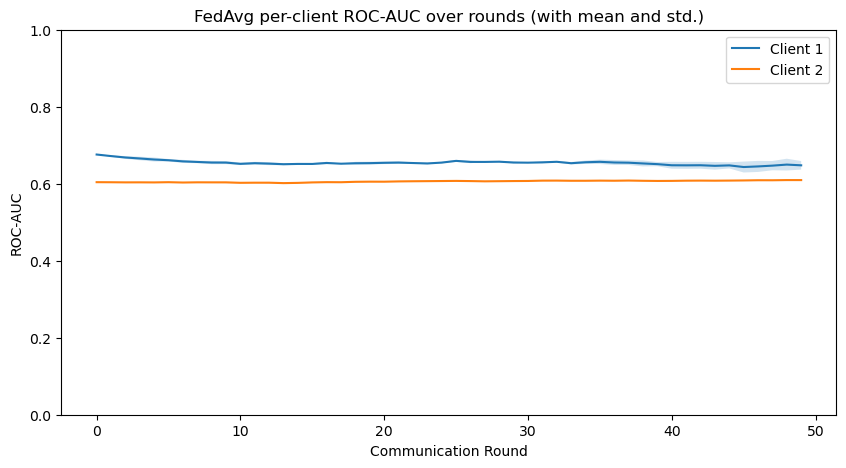

In [71]:
def plot_multi_clients_roc_auc(mean_histories, std_histories, client_ids, ylim=(0.5, 0.7)):
    plt.figure(figsize=(10, 5))
    x = np.arange(len(next(iter(mean_histories.values()))['roc_auc']))  # rounds
    
    for idx, client_id in enumerate(client_ids):
        mean = mean_histories[client_id]['roc_auc']
        std = std_histories[client_id]['roc_auc']
        plt.plot(x, mean, label=f"Client {idx + 1}")  # use idx + 1 for label
        plt.fill_between(x, mean - std, mean + std, alpha=0.2)

    plt.xlabel("Communication Round")
    plt.ylabel("ROC-AUC")
    plt.title("FedAvg per-client ROC-AUC over rounds (with mean and std.)")
    plt.ylim(ylim)
    plt.legend()
    plt.show()

# Call it:
plot_multi_clients_roc_auc(mean_per_client_histories, std_per_client_histories, client_ids=["0", "1"], ylim=(0, 1))

### Check which seed is median

In [164]:
final_aucs = [(seed, all_global_histories['global_roc_auc'][i][-1]) for i, seed in enumerate(seeds)]
median_seed = sorted(final_aucs, key=lambda x: x[1])[1][0]
print(f"Median seed based on final ROC-AUC: {median_seed}")

Median seed based on final ROC-AUC: 42


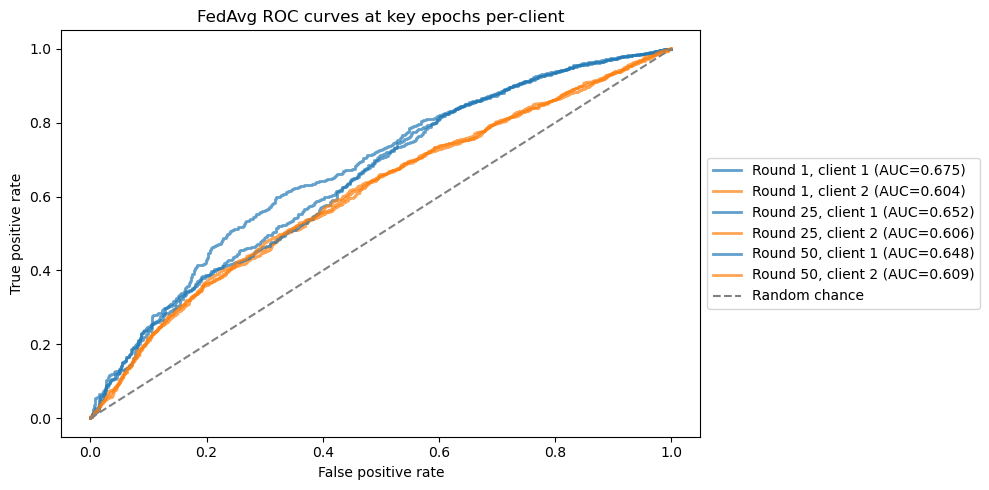

In [157]:
with open("results/fl/seed_42/roc_curves.json") as f:
    roc_history_raw = json.load(f)

# Convert string keys to tuples without modifying the dict during iteration
roc_history = {}
for k_str, value in roc_history_raw.items():
    key_tuple = eval(k_str)  
    roc_history[key_tuple] = value  

plt.figure(figsize=(10, 5))
client_colors = {0: "C0", 1: "C1"}  

for (rnd, client), (fpr, tpr, auc_val) in sorted(roc_history.items()):
    color = client_colors.get(client, "black") 
    label = f"Round {rnd}, client {client+1} (AUC={auc_val:.3f})"
    plt.plot(fpr, tpr, label=label, color=color, alpha=0.7, linewidth=2)

plt.plot([0, 1], [0, 1], "--", color="gray", label="Random chance")

plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("FedAvg ROC curves at key epochs per-client")
plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.tight_layout()
plt.show()


### Table creation

In [166]:
seeds = [42, 1337, 7]
metric_keys = ['global_loss', 'global_accuracy', 'global_precision', 'global_recall', 'global_f1',
               'global_roc_auc', 'global_pr_auc'] 

results = {key: [] for key in metric_keys}

for seed in seeds:
    with open(f"results/fl/seed_{seed}/history.json", "r") as f:
        hist = json.load(f)
        for key in metric_keys:
            results[key].append(hist[key][-1])

# Calculate mean and standard deviation for each metric
final_global_summary = {}
for key in metric_keys:
    values = np.array(results[key]) # Convert list to numpy array for calculations
    mean_val = np.mean(values)
    std_val = np.std(values)
    final_global_summary[key] = f"{mean_val:.4f} \u00B1 {std_val:.4f}" #

print("Global metrics (Final Round, mean ± std dev across seeds):")
for key, value in final_global_summary.items():
    print(f"{key}: {value}")

Global metrics (Final Round, mean ± std dev across seeds):
global_loss: 1.3140 ± 0.1108
global_accuracy: 0.0702 ± 0.0000
global_precision: 0.0000 ± 0.0000
global_recall: 0.0000 ± 0.0000
global_f1: 0.0000 ± 0.0000
global_roc_auc: 0.6266 ± 0.0045
global_pr_auc: 0.9532 ± 0.0008


In [131]:
all_per_client_histories = {client_id: {key: [] for key in per_client_metrics_keys}
                            for client_id in client_ids}

for seed in seeds:
    seed_path = f"results/fl/seed_{seed}"
    with open(f"{seed_path}/per_client_history.json", "r") as f:
        per_client_hist = json.load(f)
    
    for client_id in client_ids:
        for key in per_client_metrics_keys:
            all_per_client_histories[client_id][key].append(per_client_hist[key][client_id])

mean_per_client_histories = {}
std_per_client_histories = {}

for client_id in client_ids:
    mean_per_client_histories[client_id] = {}
    std_per_client_histories[client_id] = {}
    for key in per_client_metrics_keys:
        # Convert list of lists to numpy array for this client and metric
        data_for_key = np.array(all_per_client_histories[client_id][key])
        
        # Calculate mean and std dev for the *final round* values
        mean_per_client_histories[client_id][key] = np.mean(data_for_key[:, -1])
        std_per_client_histories[client_id][key] = np.std(data_for_key[:, -1]) 

print("Per-client metrics (Final Round, mean ± std dev across seeds):")
for client_id in client_ids:
    print(f"\nClient {client_id}:")
    for key in per_client_metrics_keys:
        mean_val = mean_per_client_histories[client_id][key]
        std_val = std_per_client_histories[client_id][key]
        print(f"{key}: {mean_val:.4f} ± {std_val:.4f}")

Per-client metrics (Final Round, mean ± std dev across seeds):

Client 0:
roc_auc: 0.6478 ± 0.0111
pr_auc: 0.9573 ± 0.0018
loss: 1.5439 ± 0.1252
accuracy: 0.0686 ± 0.0000
precision: 0.0000 ± 0.0000
recall: 0.0000 ± 0.0000
f1: 0.0000 ± 0.0000

Client 1:
roc_auc: 0.6094 ± 0.0009
pr_auc: 0.9499 ± 0.0003
loss: 1.1282 ± 0.1110
accuracy: 0.0715 ± 0.0000
precision: 0.0000 ± 0.0000
recall: 0.0000 ± 0.0000
f1: 0.0000 ± 0.0000


# **Implementing FedProx**

In [34]:
class StaticMLP2(nn.Module):
    def __init__(self, input_size=6, mlp_hidden=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, mlp_hidden),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),

            nn.Linear(mlp_hidden, mlp_hidden//2),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),

            nn.Linear(mlp_hidden//2, 1),
        )

    def forward(self, x):
        return self.net(x).squeeze(-1)

In [35]:
def train_local_model_fedprox(client_dataloader, model, global_model, pos_weight, mu=0.01, epochs=5, lr=1e-4, device='cpu'):
    model.train()
    model.to(device)
    global_model.to(device)

    # optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))

    global_params = [p.detach().clone().to(device) for p in global_model.parameters()]

    for epoch in range(epochs):
        for X_batch, y_batch in client_dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device).float()

            optimizer.zero_grad()
            logits = model(X_batch)
            loss = loss_fn(logits, y_batch)

            # Proximal term
            prox_term = 0.0
            for param, gparam in zip(model.parameters(), global_params):
                prox_term += torch.sum((param - gparam) ** 2)

            loss = loss + (mu / 2) * prox_term
            loss.backward()
            optimizer.step()
            
    return model

### Selecting clients adaptively



In [36]:
def federated_prox(global_model, train_loaders, test_loaders, pos_weights, num_rounds=10, mu=0.01, epochs=5, lr=1e-4, device='cpu'):
    num_clients = len(train_loaders)
    sizes       = [len(dl.dataset) for dl in train_loaders]
    total_size  = sum(sizes) if sum(sizes) > 0 else 1
    rounds_to_snapshot = {1, num_rounds//2, num_rounds}
    
    history = {
        'global_roc_auc': [], 'global_pr_auc': [], 'global_loss': [], 'global_accuracy': [],
        'global_precision': [], 'global_recall': [], 'global_f1': []
    }
    per_client_history = {
        'roc_auc': {i: [] for i in range(num_clients)}, 'pr_auc' : {i: [] for i in range(num_clients)},
        'loss': {i: [] for i in range(num_clients)}, 'accuracy': {i: [] for i in range(num_clients)},
        'precision': {i: [] for i in range(num_clients)}, 'recall': {i: [] for i in range(num_clients)},
        'f1': {i: [] for i in range(num_clients)}
    }
    roc_history_prox = {}  

    for round_loop_var in range(1, num_rounds+1): 
        print(f"\nSTARTING ROUND {round_loop_var}/{num_rounds}")
        local_models = []
        round_update_magnitudes = []

        for i in range(num_clients):
            local = copy.deepcopy(global_model)
            trained = train_local_model_fedprox(
                train_loaders[i], local, global_model, pos_weights[i],
                mu=mu, epochs=epochs, lr=lr, device=device
            )

            update_norm = torch.norm(
                torch.cat([
                    (trained_param - global_param).detach().flatten()
                    for trained_param, global_param in zip(trained.parameters(), global_model.parameters())
                ])
            ).item()
            round_update_magnitudes.append(update_norm)
            
            local_models.append(trained)
    
        if 'update_magnitudes' not in history:
            history['update_magnitudes'] = []
        history['update_magnitudes'].append(round_update_magnitudes)

        with torch.no_grad():
            for p in global_model.parameters():
                p.data.zero_()
            for i, local in enumerate(local_models):
                w = sizes[i] / total_size if total_size > 0 else 1/num_clients
                for gp, lp in zip(global_model.parameters(), local.parameters()):
                    gp.data += w * lp.data
                    
        if round_loop_var in rounds_to_snapshot:
            for i in range(num_clients):
                _, _, _, _, _, roc_auc_snap, _, fpr_snap, tpr_snap = evaluate_model(
                    global_model, test_loaders[i], pos_weights[i], device
                )
                roc_history_prox[(round_loop_var, i)] = (fpr_snap, tpr_snap, roc_auc_snap)

        client_losses, client_accs, client_precisions, client_recalls, client_f1s = [], [], [], [], []
        client_roc_aucs, client_pr_aucs = [], [] 

        for i in range(num_clients):
            loss, acc, precision, recall, f1, roc, pr, _, _ = evaluate_model(
                global_model, test_loaders[i], pos_weights[i], device=device
            )
            print(f" Client {i+1} Loss {loss:.3f} | Acc {acc:.3f} | Precision {precision:.3f} | Recall {recall:.3f} | F1 {f1:.3f} | ROC AUC {roc:.3f} | PR AUC {pr:.3f}")
            
            per_client_history['loss'][i].append(loss)
            per_client_history['accuracy'][i].append(acc)
            per_client_history['precision'][i].append(precision)
            per_client_history['recall'][i].append(recall)
            per_client_history['f1'][i].append(f1)
            per_client_history['roc_auc'][i].append(roc)
            per_client_history['pr_auc'][i].append(pr)
            
            client_losses.append(loss * sizes[i])
            client_accs.append(acc * sizes[i])
            client_precisions.append(precision * sizes[i])
            client_recalls.append(recall * sizes[i])
            client_f1s.append(f1 * sizes[i])
            client_roc_aucs.append(roc * sizes[i])
            client_pr_aucs.append(pr * sizes[i])

        avg_loss = sum(client_losses) / total_size if total_size > 0 else 0
        avg_acc = sum(client_accs) / total_size if total_size > 0 else 0
        avg_precision = sum(client_precisions) / total_size if total_size > 0 else 0
        avg_recall = sum(client_recalls) / total_size if total_size > 0 else 0
        avg_f1 = sum(client_f1s) / total_size if total_size > 0 else 0
        avg_roc = sum(client_roc_aucs) / total_size if total_size > 0 else 0
        avg_pr  = sum(client_pr_aucs) / total_size if total_size > 0 else 0

        history['global_loss'].append(avg_loss)
        history['global_accuracy'].append(avg_acc)
        history['global_precision'].append(avg_precision)
        history['global_recall'].append(avg_recall)
        history['global_f1'].append(avg_f1)
        history['global_roc_auc'].append(avg_roc)
        history['global_pr_auc'].append(avg_pr)
        print(f"Global avg Loss {avg_loss:.3f} | Acc {avg_acc:.3f} | Precision {avg_precision:.3f} | Recall {avg_recall:.3f} | F1 {avg_f1:.3f} | ROC AUC {avg_roc:.3f} | PR AUC {avg_pr:.3f}")

    return global_model, history, per_client_history, roc_history_prox

### FedProx with adaptive weighting implemented

In [37]:
seeds = [42, 1337, 7]
for seed in seeds:
    print(f"\n--- FedProx Training (Seed {seed}) ---")
    # Set random seed
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    # Init model
    global_model = StaticMLP(input_size=Xs_tr_match1.shape[1], mlp_hidden=256).to(device)

    # Run training
    model, history, per_client_hist, roc_hist = federated_prox(
        global_model=global_model,
        train_loaders=train_loaders,
        test_loaders=test_loaders,
        pos_weights=pos_weights,
        num_rounds=50,
        mu=0.001,
        epochs=5,
        lr=1e-4,
        device=device
    )

    # Save
    seed_path = f"results/fedprox/seed_{seed}"
    os.makedirs(seed_path, exist_ok=True)

    with open(f"{seed_path}/history.json", "w") as f:
        json.dump(history, f)
    with open(f"{seed_path}/per_client_history.json", "w") as f:
        json.dump(per_client_hist, f)
    roc_hist_serializable = {str(k): (v[0].tolist(), v[1].tolist(), v[2]) for k, v in roc_hist.items()}
    with open(f"{seed_path}/roc_curves.json", "w") as f:
        json.dump(roc_hist_serializable, f)

    print(f"Finished FedProx seed {seed}, saved to {seed_path}")


--- FedProx Training (Seed 42) ---

STARTING ROUND 1/50
 Client 1 Loss 1.738 | Acc 0.069 | Precision 0.000 | Recall 0.000 | F1 0.000 | ROC AUC 0.672 | PR AUC 0.961
 Client 2 Loss 1.325 | Acc 0.071 | Precision 0.000 | Recall 0.000 | F1 0.000 | ROC AUC 0.603 | PR AUC 0.949
Global avg Loss 1.509 | Acc 0.070 | Precision 0.000 | Recall 0.000 | F1 0.000 | ROC AUC 0.634 | PR AUC 0.955

STARTING ROUND 2/50
 Client 1 Loss 2.161 | Acc 0.069 | Precision 0.000 | Recall 0.000 | F1 0.000 | ROC AUC 0.671 | PR AUC 0.961
 Client 2 Loss 1.616 | Acc 0.071 | Precision 0.000 | Recall 0.000 | F1 0.000 | ROC AUC 0.604 | PR AUC 0.950
Global avg Loss 1.860 | Acc 0.070 | Precision 0.000 | Recall 0.000 | F1 0.000 | ROC AUC 0.634 | PR AUC 0.955

STARTING ROUND 3/50
 Client 1 Loss 2.224 | Acc 0.069 | Precision 0.000 | Recall 0.000 | F1 0.000 | ROC AUC 0.667 | PR AUC 0.960
 Client 2 Loss 1.603 | Acc 0.071 | Precision 0.000 | Recall 0.000 | F1 0.000 | ROC AUC 0.603 | PR AUC 0.949
Global avg Loss 1.880 | Acc 0.070 |

## **Evaluation**

In [172]:
seeds = [42, 1337, 7]
global_metrics_keys = ['global_roc_auc', 'global_pr_auc', 'global_loss', 
                       'global_accuracy', 'global_precision', 'global_recall', 'global_f1']
per_client_metrics_keys = ['roc_auc', 'pr_auc', 'loss', 
                           'accuracy', 'precision', 'recall', 'f1']
client_ids = ["0", "1"] 

# Initialize dictionaries to store data from all seeds
all_global_histories = {key: [] for key in global_metrics_keys}
all_per_client_histories = {client_id: {key: [] for key in per_client_metrics_keys} 
                            for client_id in client_ids}

# Load data for each seed
for seed in seeds:
    seed_path = f"results/fedprox/seed_{seed}"
    
    with open(f"{seed_path}/history.json", "r") as f:
        history = json.load(f)
    with open(f"{seed_path}/per_client_history.json", "r") as f:
        per_client_hist = json.load(f)
    
    # Store global metrics
    for key in global_metrics_keys:
        all_global_histories[key].append(history[key])
        
    # Store per-client metrics
    for client_id in client_ids:
        for key in per_client_metrics_keys:
            all_per_client_histories[client_id][key].append(per_client_hist[key][client_id])

# Convert lists of lists to numpy arrays for easier calculation
for key in global_metrics_keys:
    all_global_histories[key] = np.array(all_global_histories[key])

for client_id in client_ids:
    for key in per_client_metrics_keys:
        all_per_client_histories[client_id][key] = np.array(all_per_client_histories[client_id][key])

# Calculate mean and std dev across seeds for plotting
mean_global_histories = {key: np.mean(all_global_histories[key], axis=0) 
                         for key in global_metrics_keys}
std_global_histories = {key: np.std(all_global_histories[key], axis=0) 
                        for key in global_metrics_keys}

mean_per_client_histories = {client_id: {key: np.mean(all_per_client_histories[client_id][key], axis=0) 
                                        for key in per_client_metrics_keys}
                            for client_id in client_ids}
std_per_client_histories = {client_id: {key: np.std(all_per_client_histories[client_id][key], axis=0) 
                                      for key in per_client_metrics_keys}
                           for client_id in client_ids}

# Calculate final round statistics for tables
final_round_global_metrics = {}
for key in global_metrics_keys:
    mean_val = mean_global_histories[key][-1]
    std_val = std_global_histories[key][-1]
    final_round_global_metrics[key] = f"{mean_val:.4f} \u00B1 {std_val:.4f}" # \u00B1 is plus-minus sign

final_round_per_client_metrics = {}
for client_id in client_ids:
    final_round_per_client_metrics[client_id] = {}
    for key in per_client_metrics_keys:
        mean_val = mean_per_client_histories[client_id][key][-1]
        std_val = std_per_client_histories[client_id][key][-1]
        final_round_per_client_metrics[client_id][key] = f"{mean_val:.4f} \u00B1 {std_val:.4f}"

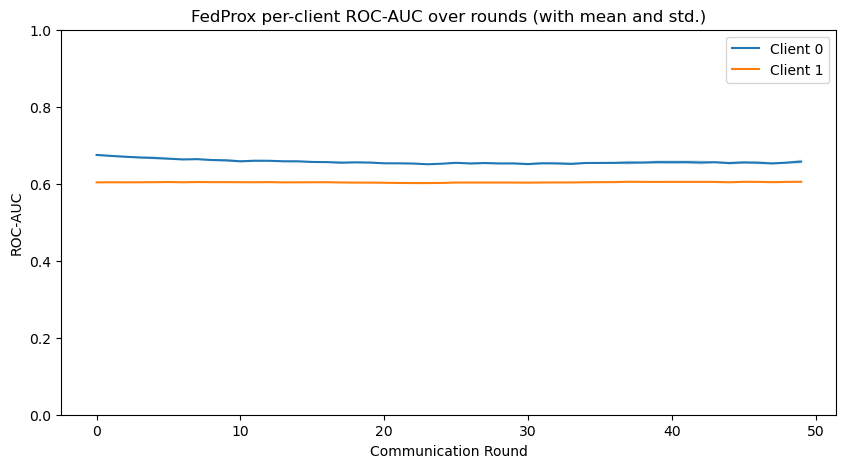

In [173]:
def plot_multi_clients_roc_auc(mean_histories, std_histories, client_ids, ylim=(0.5, 0.7)):
    plt.figure(figsize=(10, 5))
    x = np.arange(len(next(iter(mean_histories.values()))['roc_auc']))  # rounds
    
    for client_id in client_ids:
        mean = mean_histories[client_id]['roc_auc']
        std = std_histories[client_id]['roc_auc']
        plt.plot(x, mean, label=f"Client {client_id}")
        plt.fill_between(x, mean - std, mean + std, alpha=0.2)

    plt.xlabel("Communication Round")
    plt.ylabel("ROC-AUC")
    plt.title("FedProx per-client ROC-AUC over rounds (with mean and std.)")
    plt.ylim(ylim)
    plt.legend()
    plt.show()

# Call it:
plot_multi_clients_roc_auc(mean_per_client_histories, std_per_client_histories, client_ids=["0", "1"], ylim=(0, 1))

In [174]:
final_aucs = [(seed, all_global_histories['global_roc_auc'][i][-1]) for i, seed in enumerate(seeds)]
median_seed = sorted(final_aucs, key=lambda x: x[1])[1][0]
print(f"Median seed based on final ROC-AUC: {median_seed}")

Median seed based on final ROC-AUC: 42


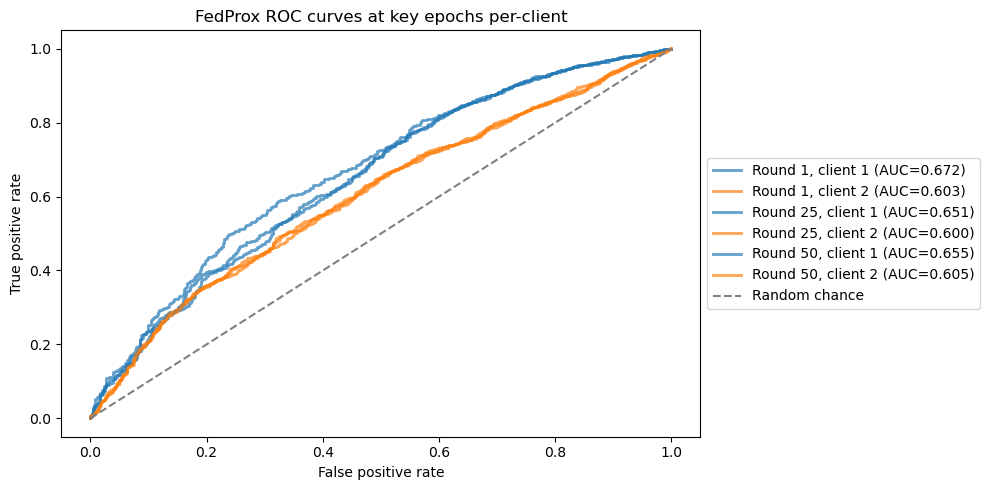

In [175]:
with open("results/fedprox/seed_42/roc_curves.json") as f:
    roc_history_raw = json.load(f)

# Convert string keys to tuples without modifying the dict during iteration
roc_history = {}
for k_str, value in roc_history_raw.items():
    key_tuple = eval(k_str)  
    roc_history[key_tuple] = value  

plt.figure(figsize=(10, 5))
client_colors = {0: "C0", 1: "C1"}  

for (rnd, client), (fpr, tpr, auc_val) in sorted(roc_history.items()):
    color = client_colors.get(client, "black") 
    label = f"Round {rnd}, client {client+1} (AUC={auc_val:.3f})"
    plt.plot(fpr, tpr, label=label, color=color, alpha=0.7, linewidth=2)

# Add random baseline
plt.plot([0, 1], [0, 1], "--", color="gray", label="Random chance")

plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("FedProx ROC curves at key epochs per-client")
plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.tight_layout()
plt.show()


In [176]:
seeds = [42, 1337, 7]
metric_keys = ['global_loss', 'global_accuracy', 'global_precision', 'global_recall', 'global_f1',
               'global_roc_auc', 'global_pr_auc'] 

results = {key: [] for key in metric_keys}

for seed in seeds:
    with open(f"results/fedprox/seed_{seed}/history.json", "r") as f:
        hist = json.load(f)
        for key in metric_keys:
            results[key].append(hist[key][-1])

# Calculate mean and standard deviation for each metric
final_global_summary = {}
for key in metric_keys:
    values = np.array(results[key]) # Convert list to numpy array for calculations
    mean_val = np.mean(values)
    std_val = np.std(values)
    final_global_summary[key] = f"{mean_val:.4f} \u00B1 {std_val:.4f}" #

print("Global metrics (final round, mean ± std dev across seeds):")
for key, value in final_global_summary.items():
    print(f"{key}: {value}")

Global metrics (final round, mean ± std dev across seeds):
global_loss: 1.7409 ± 0.1067
global_accuracy: 0.0702 ± 0.0000
global_precision: 0.0000 ± 0.0000
global_recall: 0.0000 ± 0.0000
global_f1: 0.0000 ± 0.0000
global_roc_auc: 0.6285 ± 0.0031
global_pr_auc: 0.9539 ± 0.0006


In [177]:
all_per_client_histories = {client_id: {key: [] for key in per_client_metrics_keys}
                            for client_id in client_ids}

for seed in seeds:
    seed_path = f"results/fedprox/seed_{seed}"
    with open(f"{seed_path}/per_client_history.json", "r") as f:
        per_client_hist = json.load(f)
    
    for client_id in client_ids:
        for key in per_client_metrics_keys:
            all_per_client_histories[client_id][key].append(per_client_hist[key][client_id])

mean_per_client_histories = {}
std_per_client_histories = {}

for client_id in client_ids:
    mean_per_client_histories[client_id] = {}
    std_per_client_histories[client_id] = {}
    for key in per_client_metrics_keys:
        # Convert list of lists to numpy array for this client and metric
        data_for_key = np.array(all_per_client_histories[client_id][key])
        
        # Calculate mean and std dev for the *final round* values
        mean_per_client_histories[client_id][key] = np.mean(data_for_key[:, -1])
        std_per_client_histories[client_id][key] = np.std(data_for_key[:, -1]) 

print("Per-client metrics (final round, mean ± std dev across seeds):")
for client_id in client_ids:
    print(f"\nClient {client_id}:")
    for key in per_client_metrics_keys:
        mean_val = mean_per_client_histories[client_id][key]
        std_val = std_per_client_histories[client_id][key]
        print(f"{key}: {mean_val:.4f} ± {std_val:.4f}")


Per-client metrics (final round, mean ± std dev across seeds):

Client 0:
roc_auc: 0.6575 ± 0.0057
pr_auc: 0.9592 ± 0.0012
loss: 2.0878 ± 0.1704
accuracy: 0.0686 ± 0.0000
precision: 0.0000 ± 0.0000
recall: 0.0000 ± 0.0000
f1: 0.0000 ± 0.0000

Client 1:
roc_auc: 0.6050 ± 0.0010
pr_auc: 0.9496 ± 0.0002
loss: 1.4606 ± 0.0757
accuracy: 0.0715 ± 0.0000
precision: 0.0000 ± 0.0000
recall: 0.0000 ± 0.0000
f1: 0.0000 ± 0.0000


# **Useful links**

https://keylabs.ai/blog/classification-models-in-healthcare-disease-prediction-and-diagnosis/ (Clinical dataset guide)

https://arxiv.org/pdf/1907.08322 (MIMIC Extract)

https://arxiv.org/pdf/1703.07771 (LSTM on MIMIC benchmark)

https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0211057 (LSTM model usage on clincal data)